In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import dionysus as d
import folium
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import pickle
from operator import attrgetter
from utils import util
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
os.environ['USE_PYGEOS'] = '0'

/Users/anpingzhang/miniconda3/envs/zigzag/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/gk/6vxrxpj902zdzw3_82kc20k40000gn/T/ipykernel_74152/3170041203.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this 

### Load volunteer data and Shenzhen geometric boundaries

In [2]:
#load volunteering dataset
df_washed = pd.read_parquet('./data/volunteer_acticities.parquet').set_index('issued_time')
df_washed = df_washed.set_index(pd.to_datetime(df_washed.index)).drop_duplicates().sort_index()
#load Shenzhen's city, district and street polygon
street_polygon = pd.read_csv('./data/street_polygon.csv',index_col=0)
district_polygon = pd.read_csv('./data/district_polygon.csv',index_col=0)
with open('./data/shenzhen_polygon.json') as f:
    shenzhen_polygon = json.load(f)

In [3]:
#dgms to betti curves 
def normalize(array):
    return (array - min(array))/ (max(array) - min(array)) 
def Get_betti_curve(dgms, iters, SWL, OL): 
    dgm_1dim = {}
    window_count = int((iters - SWL) / OL)
    for idx,dgm in enumerate(dgms):
        dgm_1dim[f'dim_{idx}'] = np.zeros(iters)
        points = [(int(point.birth), int(point.death) if point.death != float('inf') else window_count) for point in dgm] #if point.death != float('inf') and int(point.death) - int(point.birth) > 0]
        for i in points:
            start = i[0] * OL
            end = min(i[1] * OL + SWL, iters)  
            dgm_1dim[f'dim_{idx}'][start:end] += 1
    return dgm_1dim

### Figure 1: Different collaboration patterns among group emerging from volunteer activities 

In [4]:
def generate_date_strings(start_date, end_date, date_format="%Y-%m-%d"):
    """
    Generate a list of date strings between start_date and end_date.

    :param start_date: The start date as a string.
    :param end_date: The end date as a string.
    :param date_format: The format of the input and output dates. Default is YYYY-MM-DD.
    :return: A list of date strings.
    """
    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)
    
    date_list = []
    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime(date_format))
        current_date += timedelta(days=1)
    
    return date_list

start = "2020-02-14"
end = "2023-09-30"
date_strings = generate_date_strings(start, end)

In [5]:
def bezier_curve(start, control, end, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.array([
        (1 - t) ** 2 * start[0] + 2 * (1 - t) * t * control[0] + t ** 2 * end[0],
        (1 - t) ** 2 * start[1] + 2 * (1 - t) * t * control[1] + t ** 2 * end[1],
    ]).T
    return LineString(curve)

def curved_line(start, end, curvature=0.2, num_points=100):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    # Compute the length
    length = np.hypot(dx, dy)
    if length == 0:
        return LineString([start, end])
    ux = dx / length
    uy = dy / length
    nx = -uy
    ny = ux
    mx = (start[0] + end[0]) / 2
    my = (start[1] + end[1]) / 2
    offset = curvature * length
    cx = mx + nx * offset
    cy = my + ny * offset
    return bezier_curve(start, [cx, cy], end, num_points=num_points)

In [6]:
def map_visualization_real_data(df, group_min_size, overlap_threshold, if_save=False,file_name = None, line_trans = 1):
    organizer_user_dict = df.groupby(['organizer_id'], sort=True)[["user_id"]].agg({"user_id": lambda x: tuple(set(x))}).iloc[:,0].to_dict()
    organizer_user_dict = {k: v for k, v in organizer_user_dict.items() if len(v) > group_min_size}
    
    def colorbar_range(data):
        data = np.array(data)
        min_value = np.min(data)
        max_value = np.max(data)
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        colorbar_min = max(min_value, lower_bound)
        colorbar_max = min(max_value, upper_bound)
        return colorbar_min, colorbar_max
    
    vmin,vmax = colorbar_range([len(i) for _,i in organizer_user_dict.items()])


    circle_markers = []
    lines = []
    colormap = folium.LinearColormap(colors=['#60A5FA', '#152D73'], vmin=vmin, vmax=vmax)

    for organizer, user_group in organizer_user_dict.items():
        latitude = np.mean(df[df.organizer_id == organizer].latitude)
        longitude = np.mean(df[df.organizer_id == organizer].longitude) 
        color = colormap(len(user_group))
        circle_marker = {
            'geometry': Point(longitude, latitude),
            'organizer_id': organizer,
            'user_count': len(user_group),
            'color': color
        }
        circle_markers.append(circle_marker)

    keys = list(organizer_user_dict.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            key1 = keys[i]
            key2 = keys[j]
            set1 = set(organizer_user_dict[key1])
            set2 = set(organizer_user_dict[key2])
            overlap = set1 & set2
            union = set1 | set2
            if len(overlap) > overlap_threshold * len(union):
                loc1 = [
                    np.mean(df[df.organizer_id == key1].longitude),
                    np.mean(df[df.organizer_id == key1].latitude)
                ]
                loc2 = [
                    np.mean(df[df.organizer_id == key2].longitude),
                    np.mean(df[df.organizer_id == key2].latitude)
                ]
                line = {
                    'geometry': curved_line(loc1, loc2, curvature=0.2, num_points=100),
                }
                lines.append(line)

    shenzhen_bounds = MultiPolygon(shenzhen_polygon['geometry']['coordinates']).bounds
    shenzhen_coords = [
        (shenzhen_bounds[0], shenzhen_bounds[3]),
        (shenzhen_bounds[2], shenzhen_bounds[3]),
        (shenzhen_bounds[2], shenzhen_bounds[1]), 
        (shenzhen_bounds[0], shenzhen_bounds[1]), 
    ]
    lines_gdf = gpd.GeoDataFrame(lines)
    lines_gdf = lines_gdf[lines_gdf.geometry.within(Polygon(shenzhen_coords))]
    circle_markers_gdf = gpd.GeoDataFrame(circle_markers)
    circle_markers_gdf = circle_markers_gdf[circle_markers_gdf.geometry.within(Polygon(shenzhen_coords))]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    district_polygon['geometry'] = district_polygon['polygon'].apply(util.parse_multipolygon)
    streets_gdf = gpd.GeoDataFrame(district_polygon, geometry='geometry')
    streets_gdf.plot(ax=ax, edgecolor='black', color='white', alpha=1)

    circle_markers_gdf.plot(ax=ax, color=circle_markers_gdf['color'], markersize=5, alpha=1)

    lines_gdf.plot(ax=ax, color='#E71D36', linewidth=0.5, alpha=line_trans,linestyle='solid')
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=mcolors.Normalize(vmin=vmin, vmax=vmax), cmap=mcolors.LinearSegmentedColormap.from_list('custom_colormap', ['#60A5FA', '#152D73'])),
        cax=fig.add_axes([0.15, 0.25, 0.7, 0.02]),
        orientation='horizontal',
    )
    cbar.set_label('Group Size',fontsize=15)
    cbar.ax.tick_params(labelsize=15)  # set colorbar label size
    if if_save:
        plt.savefig(f'./map_visual_{file_name}.pdf', bbox_inches='tight')
    plt.show()

#### Figure 1a

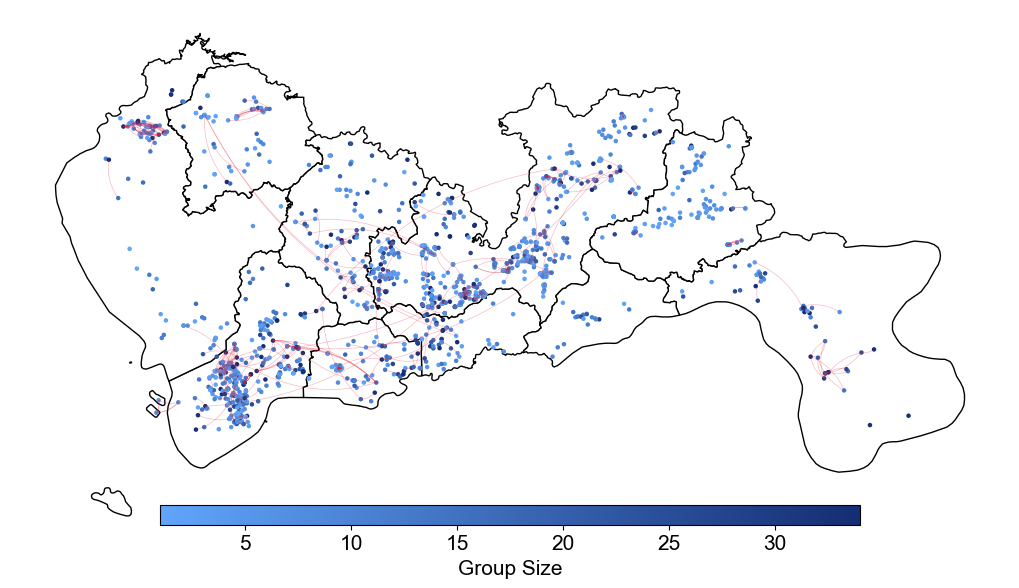

In [7]:
map_visualization_real_data(df=df_washed.loc['2021-6-14':'2021-6-21'], group_min_size=0, overlap_threshold=0,
                            if_save=False,file_name='shenzhen_20210614_20210621',line_trans=0.3)

#### Figure 1b

Saved: /Users/anpingzhang/Documents/GitHub/zigzag_on_dynamic_social_networks/figures/mapswipe_from_empirical_global.png
Saved: /Users/anpingzhang/Documents/GitHub/zigzag_on_dynamic_social_networks/figures/mapswipe_from_empirical_zoom.png


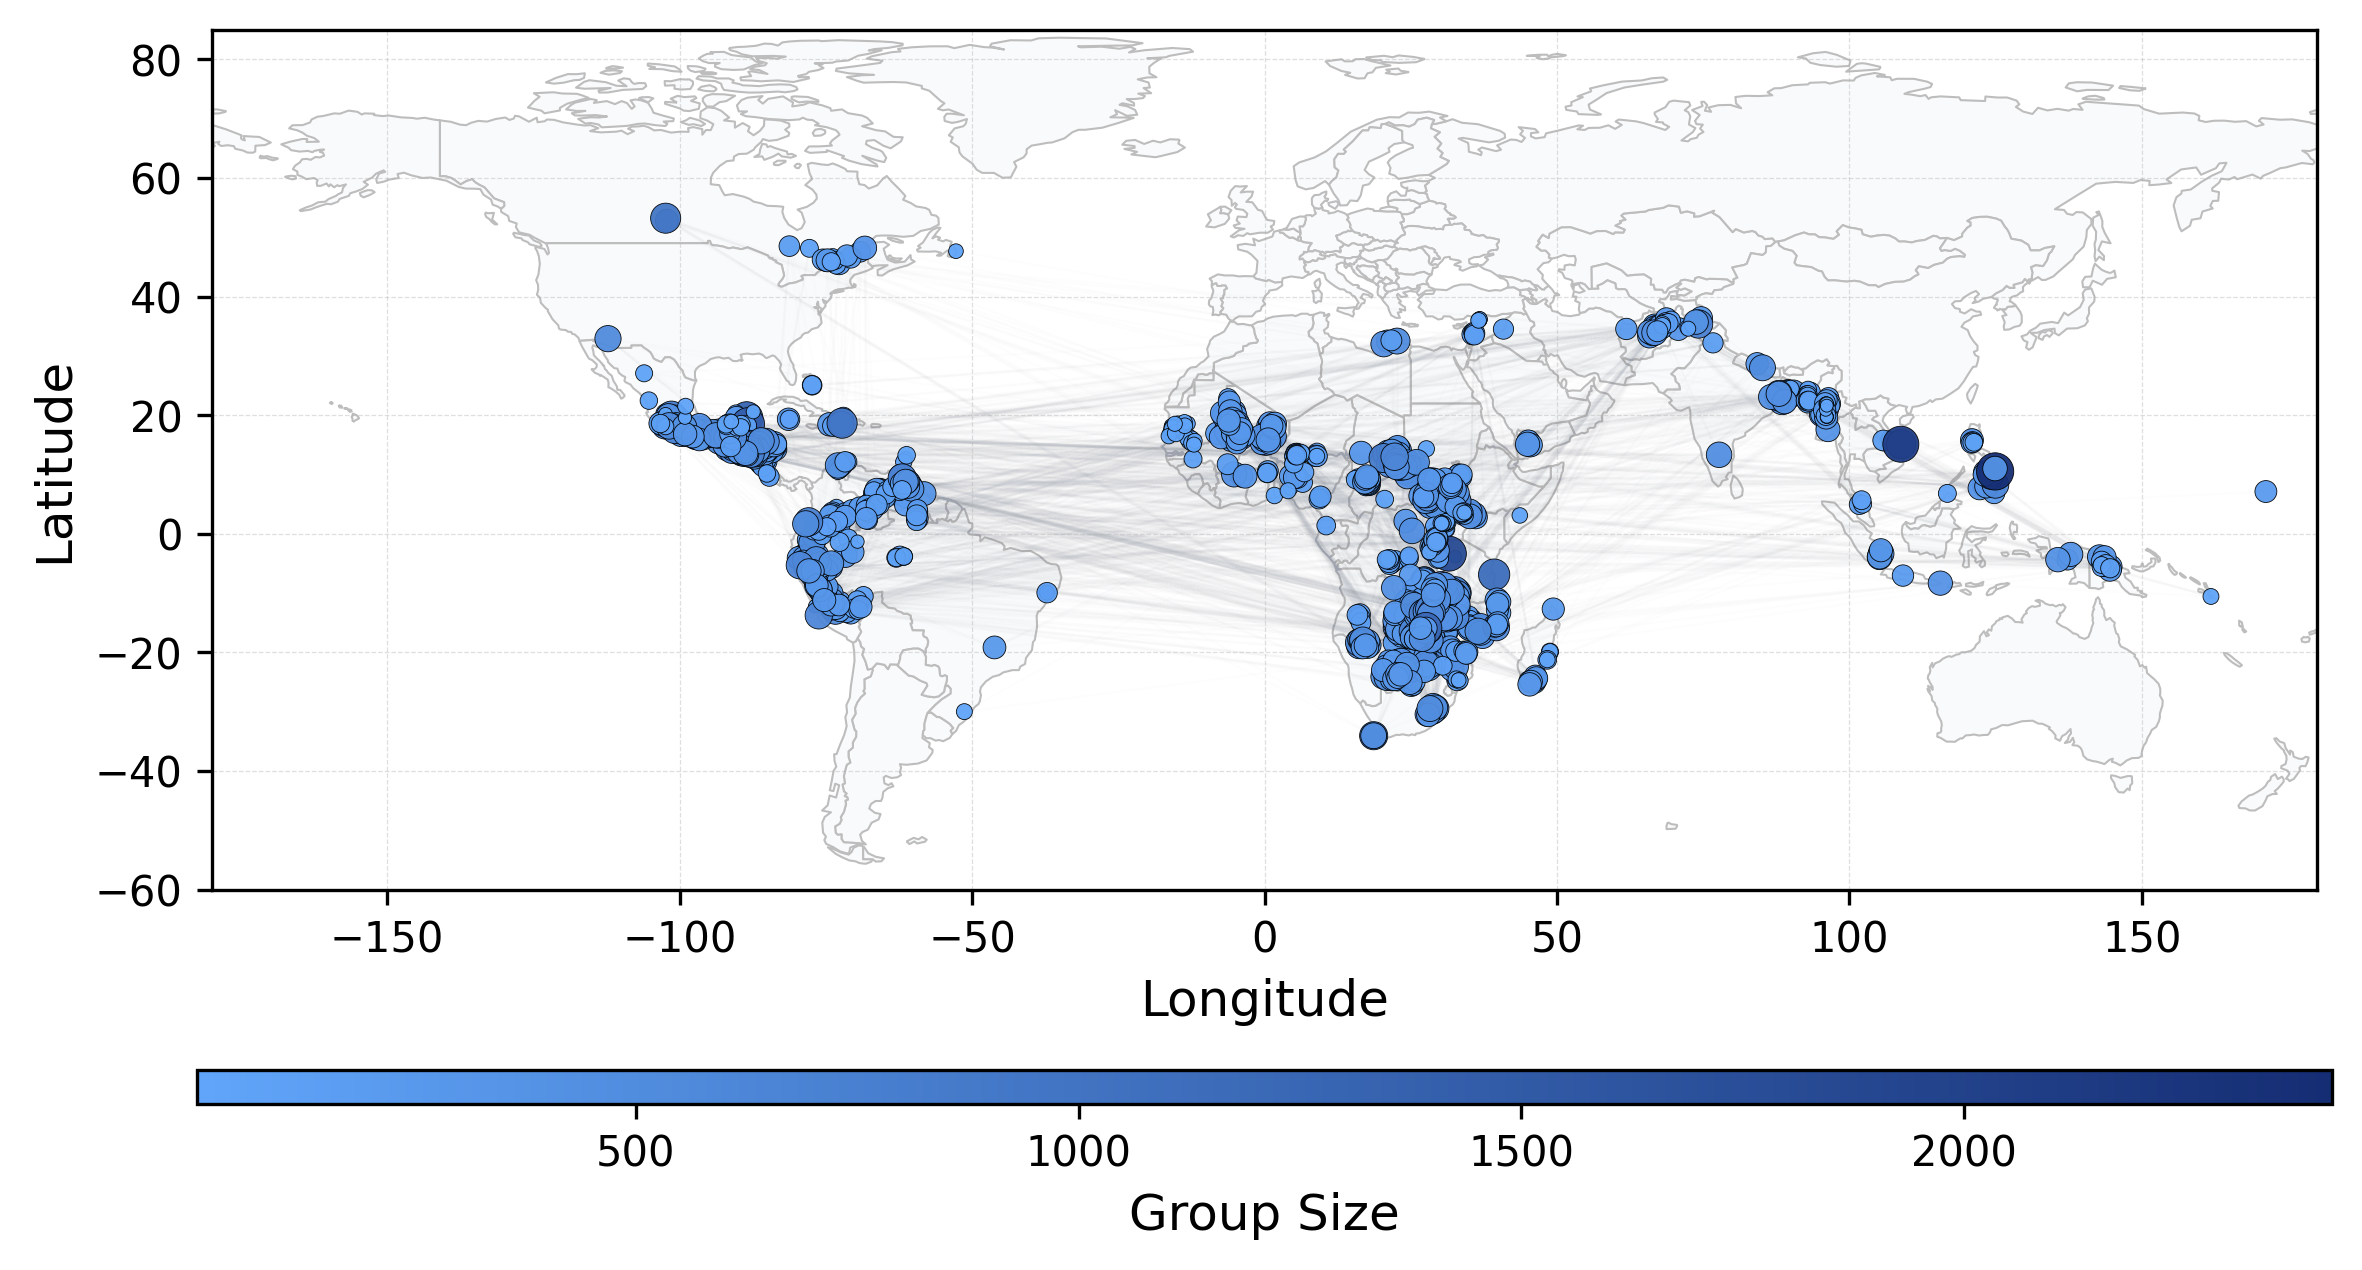

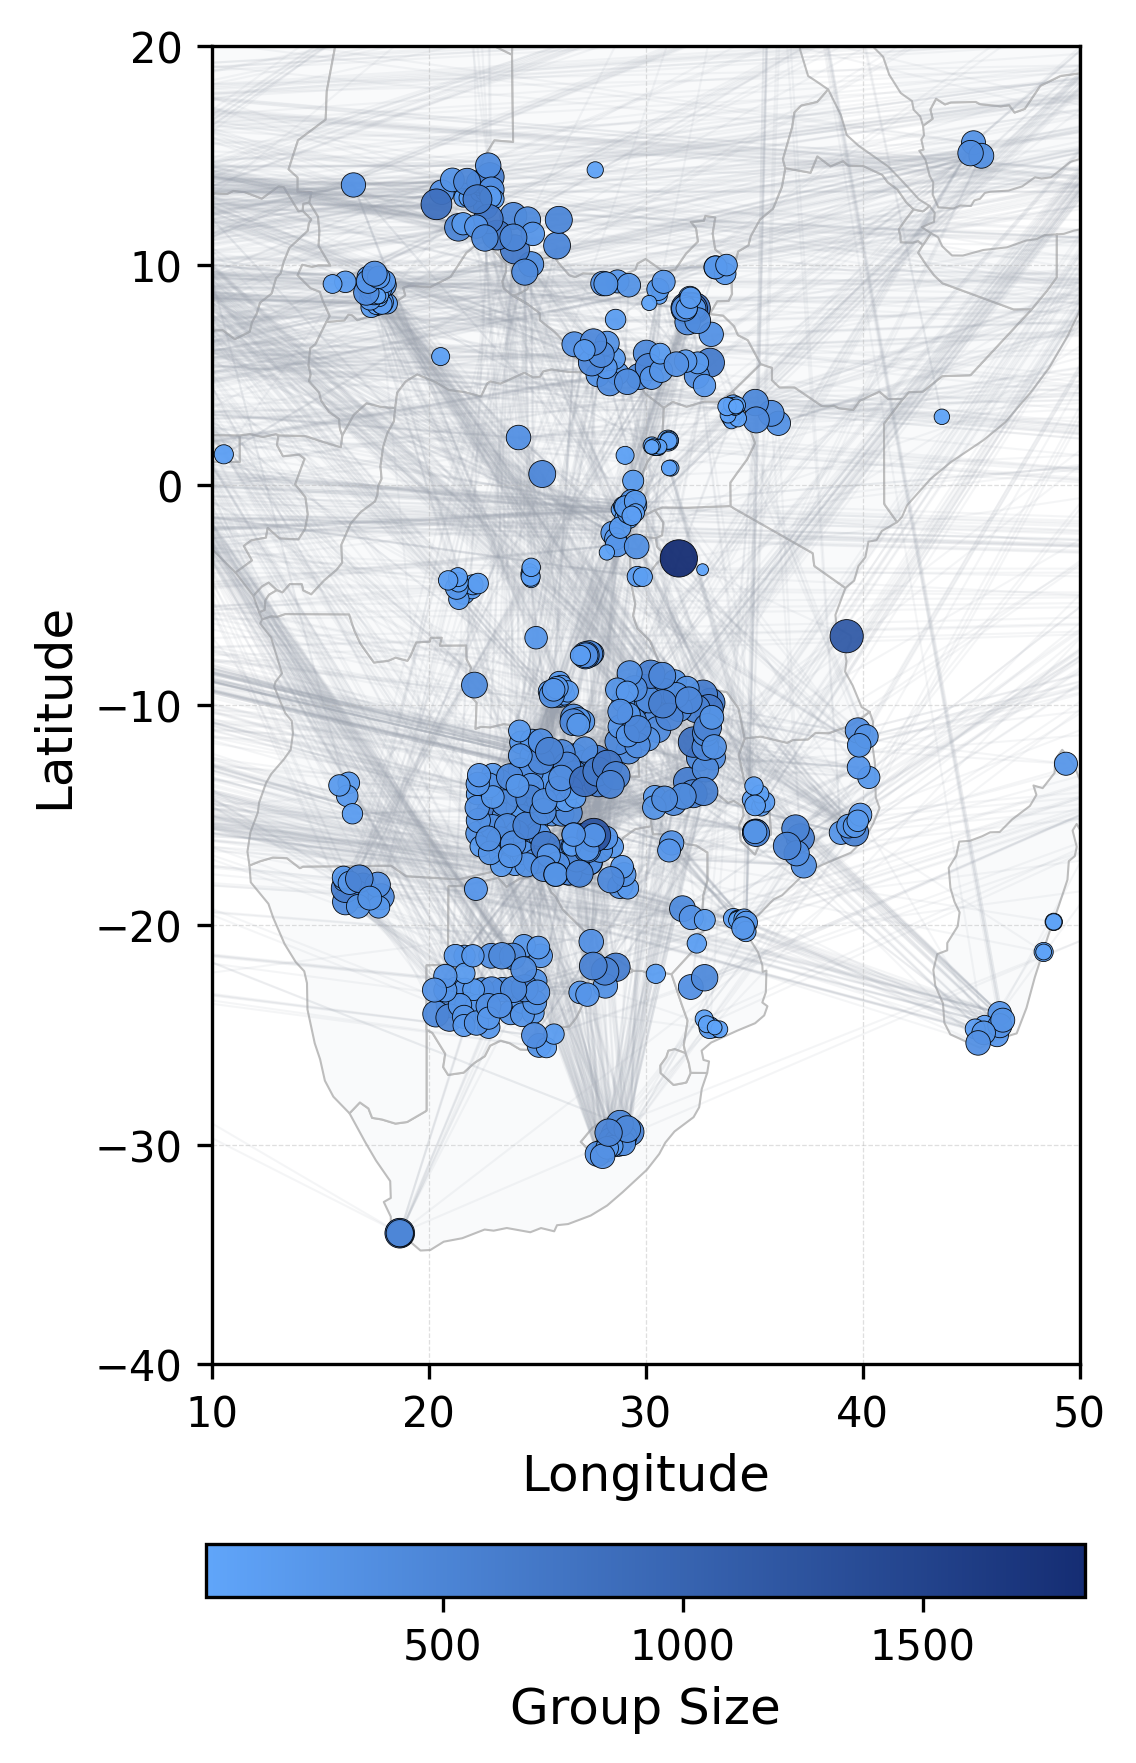

In [8]:
# Run mapswipe_visual.py and display generated images
from pathlib import Path
import subprocess
import sys
from IPython.display import Image, display

candidate_scripts = [
    Path('utils/mapswipe_visual.py'),
    Path('../utils/mapswipe_visual.py'),
]
script = next((p for p in candidate_scripts if p.exists()), None)
if script is None:
    raise FileNotFoundError('Cannot find utils/mapswipe_visual.py from current notebook working directory.')

repo_root = script.resolve().parents[1]
out_dir = repo_root / 'figures'
prefix = 'mapswipe_from_empirical'

cmd = [sys.executable, str(script), '--mode', 'both', '--output-dir', str(out_dir), '--prefix', prefix]
subprocess.run(cmd, check=True, cwd=repo_root)

global_img = out_dir / f'{prefix}_global.png'
zoom_img = out_dir / f'{prefix}_zoom.png'
display(Image(filename=str(global_img)))
display(Image(filename=str(zoom_img)))


### Figure 3 Topological analaysis of a dynamic collaboration graph

In [9]:
def zigzag_persistence(sc_list:list, times):
    f = d.Filtration(sc_list)
    _, dgms, _ = d.zigzag_homology_persistence(f, times)
    return dgms

In [10]:
def persistence_barcode_plot(dgms, range_max=50, verbose=False, save_path='./results/plots/plot.pdf'):
    '''
    Plot persistence barcode given dgms
    Input:
        dgms: list of persistence diagrams for each dimension
    '''
    plt.figure(figsize=(10, 3))
    
    color_list = ['#E72929', '#1B1A55', '#4169E1']
    y_offset = 0
    
    for dim, diagram in enumerate(dgms):
        sorted_diagram = sorted(diagram, key=attrgetter('birth'))
        y_positions = np.arange(len(sorted_diagram))*0.3 + y_offset
        
        for i, pt in enumerate(sorted_diagram):
            if np.isinf(pt.death):
                plt.plot([pt.birth, range_max], [y_positions[i], y_positions[i]], c=color_list[dim], linewidth=2)
            else:
                plt.plot([pt.birth, pt.death], [y_positions[i], y_positions[i]], c=color_list[dim], linewidth=2)
        
        # Add a small gap between dimensions
        y_offset += len(sorted_diagram)*0.3 
    
    plt.ylim(-0.3, y_offset)
    plt.yticks([])
    plt.xticks(fontsize=18)
    # plt.xticks(list(range(0, range_max+1, 5)), fontsize=12)
    plt.xlabel('Time', fontsize=15)
    plt.title('Persistence Barcode', fontsize=15)
    legend_elements = [plt.Line2D([0], [0], color=color_list[i], lw=2, label=r'$\beta$'+f'{i}') for i in range(len(dgms))]
    plt.legend(handles=legend_elements, loc=2, fontsize=15)
    
    if verbose:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [11]:
sc = [
    [1], [2], [3], [4],                   
    [1,2], [2,3], [3,1], [1,4], [2,4], [3,4], 
    [1,2,3], [1,2,4], [1,3,4], [2,3,4]    
]

times = [
    [0], [0], [0], [0],       
    [1], [1], [1],          
    [2],                      
    [4], [4],                 
    [3],                      
    [5], [5], [5]            
]
dgms = zigzag_persistence(sc, times)
print('Betti 0:',list(dgms[0]))
print('Betti 1:',list(dgms[1]))
print('Betti 2:',list(dgms[2]))

Betti 0: [(0,1), (0,1), (0,2), (0,inf)]
Betti 1: [(1,3), (4,5), (4,5)]
Betti 2: [(5,inf)]


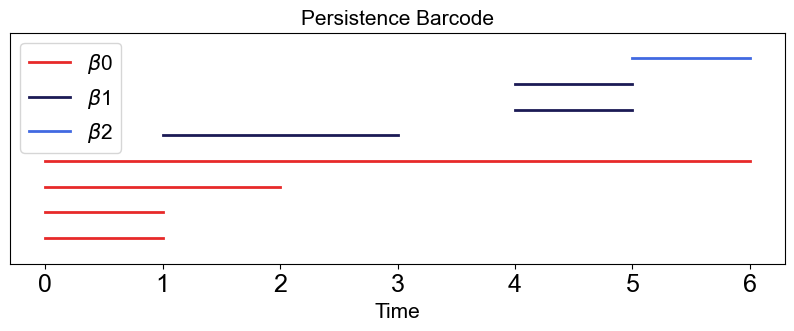

In [12]:
persistence_barcode_plot(dgms,range_max=6, verbose=False, save_path='./persistence_barcode_method.pdf')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

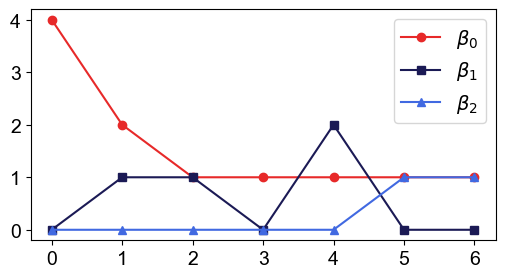

In [13]:
plt.figure(figsize=(6,3))
plt.plot([4,2,1,1,1,1,1],marker='o', label=r'$\beta_{0}$',color = '#E72929')
plt.plot([0,1,1,0,2,0,0],marker='s', label=r'$\beta_{1}$',color = '#1B1A55')
plt.plot([0,0,0,0,0,1,1],marker='^', label=r'$\beta_{2}$',color = '#4169E1')
plt.legend(fontsize = 14,loc='upper right')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.savefig('./fig3-persistence_barcode_example.pdf', bbox_inches='tight')

### Figure 4 Results on Real-world data

#### Figure 4a

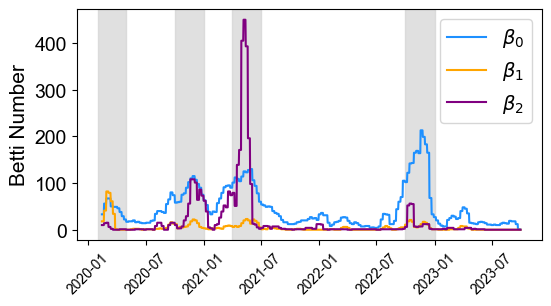

In [14]:
with open('./results/volunteer_data_results/city_level/sc_list_SWL_14_OL_7_Min_size_20_ol_10.pkl', 'rb') as file:
    sc_list = pickle.load(file)
with open('./results/volunteer_data_results/city_level/times_SWL_14_OL_7_Min_size_20_ol_10.pkl', 'rb') as file:
    times = pickle.load(file)


f = d.Filtration(sc_list)
_, dgms, _ = d.zigzag_homology_persistence(f, times)
shenzhen_betti_curve_dict = Get_betti_curve(dgms, 1325, 14, 7)
date_range = pd.date_range(start='2020-02-14', end='2023-09-30', freq='D')
user_count = [df_washed.loc[date.strftime('%Y-%m-%d')].user_id.nunique() for date in date_range]
fig, ax1 = plt.subplots(figsize=(6, 3))
line1, = ax1.plot(date_range, shenzhen_betti_curve_dict['dim_0'], label=r'$\beta_0$', color='#1E90FF') 
line2, = ax1.plot(date_range, shenzhen_betti_curve_dict['dim_1'], label=r'$\beta_1$', color='#FFA500') 
line3, = ax1.plot(date_range, shenzhen_betti_curve_dict['dim_2'], label=r'$\beta_2$', color='#800080') 
ax1.axvspan('2020-02', '2020-05', color='#D3D3D3', alpha=0.7) 
ax1.axvspan('2020-10', '2021-01', color='#D3D3D3', alpha=0.7,) 
ax1.axvspan('2021-04', '2021-07', color='#D3D3D3', alpha=0.7,) 
ax1.axvspan('2022-10', '2023-01', color='#D3D3D3', alpha=0.7,) 
ax1.set_ylabel('Betti Number', fontsize=15)
ax1.tick_params(axis='x', rotation=45)

lines_labels = [line1, line2, line3]
labels = [line.get_label() for line in lines_labels]
ax1.legend(lines_labels, labels, loc='upper right',fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('./betti_curve_shenzhen.pdf', bbox_inches='tight')
plt.show()

(array([18444., 18628., 18809., 18993., 19174., 19358., 19539.]),
 [Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

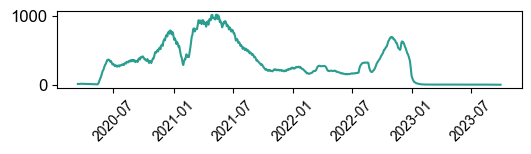

In [15]:
df_pandemic = df_washed[df_washed.task_type == 'pandemic_tasks']
df_pandemic = pd.DataFrame(df_pandemic.groupby(df_pandemic.index.date)['task_id'].nunique())
df_pandemic.index = pd.to_datetime(df_pandemic.index)
merged_df = pd.merge(pd.DataFrame(index=date_range), df_pandemic, how='left', left_index=True, right_index=True)
merged_df = merged_df.fillna(0)
plt.figure(figsize=(6, 1))
ax = plt.plot(date_range,list(merged_df.rolling(window=30).mean().task_id),color = '#2A9D8F')
plt.yticks(fontsize=12)
plt.xticks(rotation = 45)
# plt.savefig('./pandemic_tasks_count.pdf', bbox_inches='tight')

(array([    0.,  5000., 10000., 15000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000')])

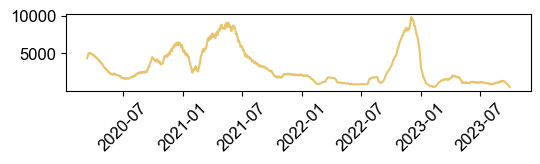

In [16]:
plt.figure(figsize=(6, 1))
plt.plot(date_range,pd.DataFrame(user_count).rolling(window=30).mean(),color = '#E9C46A')
plt.xticks(rotation = 45,fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('./user_count.pdf', bbox_inches='tight')

#### Figure 4b

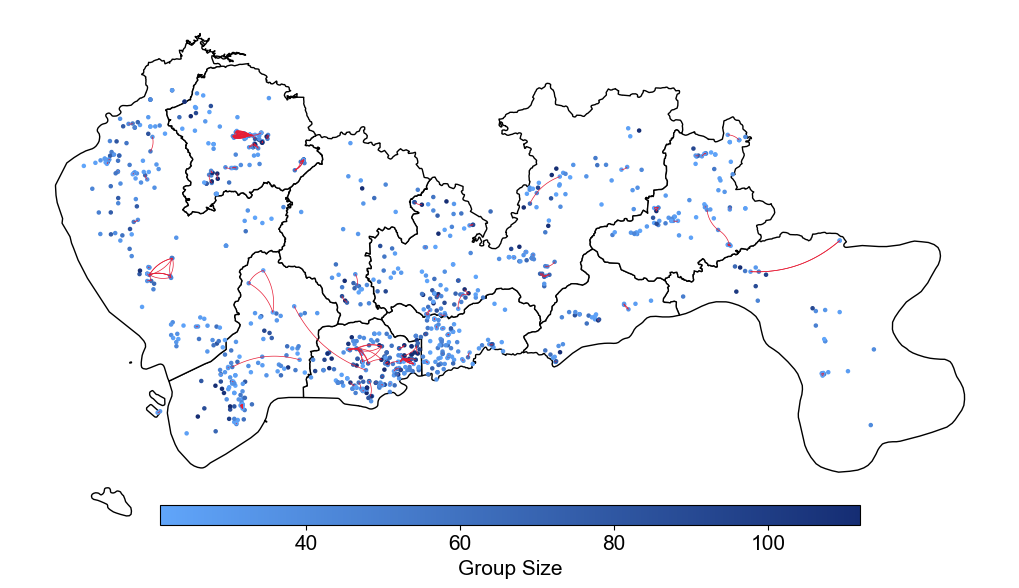

In [17]:
map_visualization_real_data(df=df_washed.loc['2020-2':'2020-5'], group_min_size=20, overlap_threshold=0.1,
                            if_save=False,file_name='shenzhen_202002_202005')

#### Figure 4c

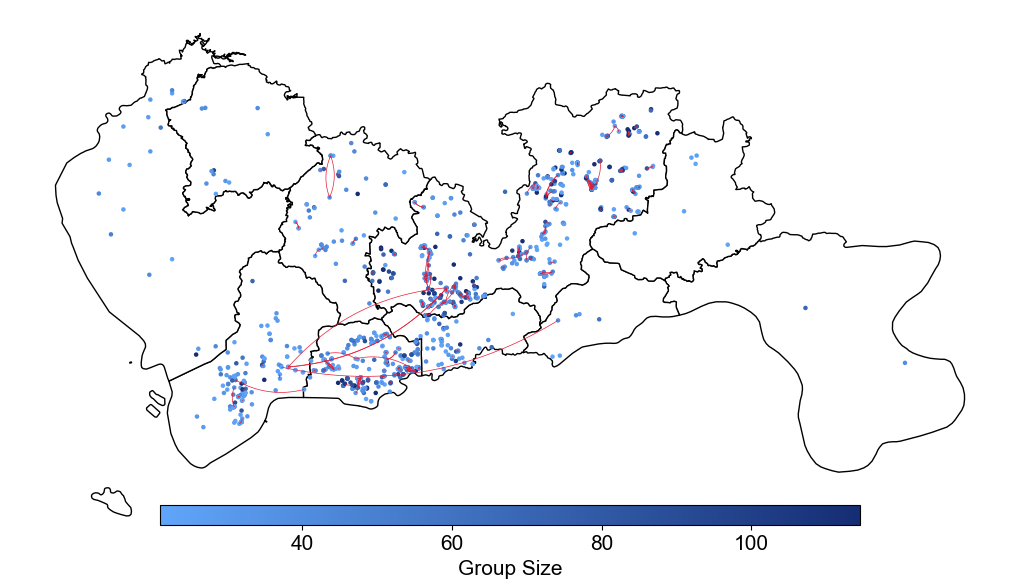

In [18]:
map_visualization_real_data(df=df_washed.loc['2020-10':'2021-01'], group_min_size=20, overlap_threshold=0.1,
                            if_save=False,file_name='shenzhen_202010_202101')

#### Figure 4d

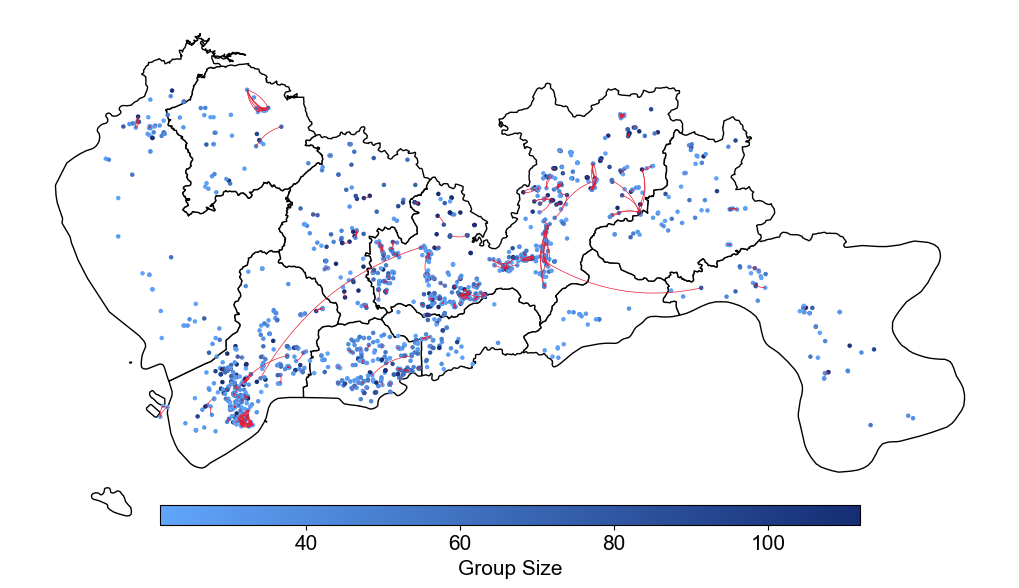

In [19]:
map_visualization_real_data(df=df_washed.loc['2021-4':'2021-7'], group_min_size=20, overlap_threshold=0.1,
                            if_save=False,file_name='shenzhen_202104_202107')

#### Figure 4e

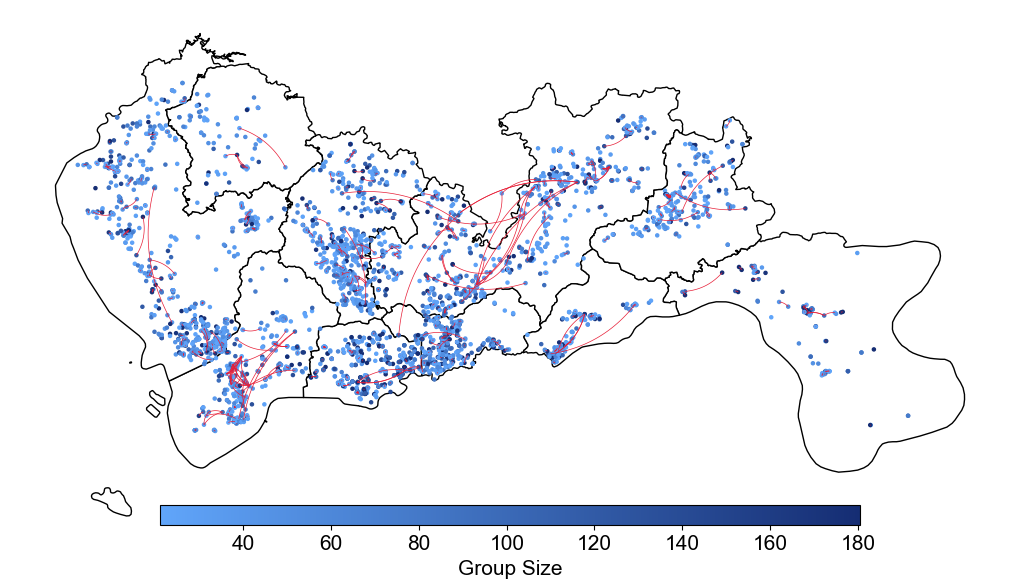

In [20]:
map_visualization_real_data(df=df_washed.loc['2022-10':'2023-1'], group_min_size=20, overlap_threshold=0.1,
                            if_save=False,file_name='shenzhen_202210_202301')